In [18]:
import pandas as pd
import hashlib
import pandahouse
import seaborn as sns
import scipy.stats as ss
import numpy as np
import matplotlib.pyplot
sns.set(rc = {'figure.figsize' : (12,6)})

In [19]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20240120'
}

# Задание 1.
у нас есть данные А/А-теста с '2023-12-22' по '2023-12-28'. Вам нужно сделать симуляцию, как будто мы провели 10000 А/А-тестов. На каждой итерации вам нужно сформировать подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы. Провести сравнение этих подвыборок t-testом.

1. Построить гистограмму распределения получившихся 10000 p-values.

2. Посчитать, какой процент p values оказался меньше либо равен 0.05

3. Написать вывод по проведенному А/А-тесту, корректно ли работает наша система сплитования. При выполнении задания важно обосновать и аргументировать ваш вывод.

### Подсоединимся к Clickhouse  и соберем датасет в который положим посчитанные по пользователям лайки, просмотры и CTR для экспериментальных групп 2 и 3

In [11]:
q = """
select exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes / views as ctr
from {db}.feed_actions
where toDate(time) between '2023-12-22' and '2023-12-28'
    and exp_group in (2,3)
    group by exp_group, user_id
"""
df = pandahouse.read_clickhouse(q, connection = connection)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16787 entries, 0 to 16786
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   exp_group  16787 non-null  int8   
 1   user_id    16787 non-null  uint32 
 2   likes      16787 non-null  uint64 
 3   views      16787 non-null  uint64 
 4   ctr        16787 non-null  float64
dtypes: float64(1), int8(1), uint32(1), uint64(2)
memory usage: 475.5 KB


In [13]:
print(f'{df[df.exp_group == 2].user_id.count()} пользователей в группе № 2')
print(f'{df[df.exp_group == 3].user_id.count()} пользователей в группе № 3')

8362 пользователей в группе № 2
8425 пользователей в группе № 3


### Всего у нас 16787 пользователей. Распределены они примерно равномерно.

### Сделаем подвыборки и проведем Т-тест 10000 раз. 
   ###       Нулевая гипотеза H0:  средние значения в распределениях групп 2 и 3 не отличаются друг от друга. 
   ###      Альтернативная гипотеза - средние значения в распределениях групп 2 и 3 статистически значимо  отличаются друг от друга.  

### Результаты запишем в перменную pvalue_dist

In [14]:
%%time
pvalue_dist = []
for _ in range(10000):
    sample_2 = df[df.exp_group == 2].sample(n=500, replace=False)
    sample_3 = df[df.exp_group == 3].sample(n=500, replace=False)

    ttest_res = ss.ttest_ind(sample_2.ctr,sample_3.ctr,equal_var = False)
    
    pvalue_dist.append(ttest_res.pvalue)
    
    
pvalue_dist = pd.Series(pvalue_dist)

CPU times: user 27.9 s, sys: 19.5 ms, total: 27.9 s
Wall time: 28.2 s


### Построим гистограмму

<Axes: ylabel='Count'>

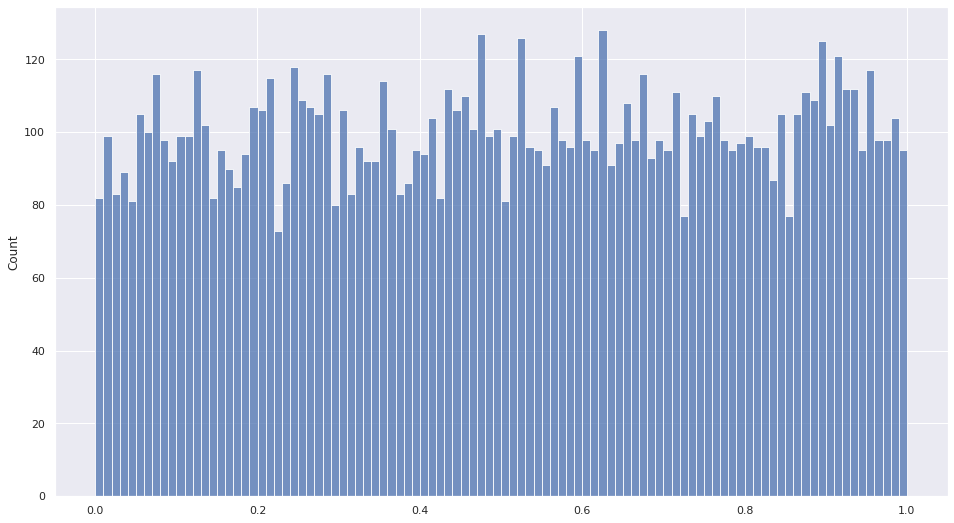

In [15]:
sns.histplot(pvalue_dist, bins = 100 )

### Определим  какой процент p-values оказался ниже или равен 0,05

In [16]:
percent = pvalue_dist[pvalue_dist <= 0.05].count() / pvalue_dist.count()*100
percent

4.32

## Выводы:
1. Пользователи в экспериментальных группах 2 и 3 распределены равномерно
2. При многократном проведении т-теста процент случаев, где p-value было меньше или равно 0.05, то есть где были обнаружены статистически значимые различия между группами оказался равен 4,69% - ниже уровня значимости. Этот результат говорит о том, что группы статистически эквивалентны.
3. Низкий процент статистически значимых различий между группами говорит о корректной работе системы сплитования. Различия, выявленные в тесте, могут быть случайными.